# Ackerman and Marley Cloud Model

Here, we try to compute a cloud opacity using Ackerman and Marley Model.
Although `atmphys.AmpAmcloud` can easily compute the parameters of the AM model,
we here try to run the methods one by one.
We consider enstatite (MgSiO3) and Fe clouds.  


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Sets a simple atmopheric model. We need the density of atmosphere.

In [2]:
from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace
from exojax.utils.astrofunc import gravity_jupiter

Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-4., log_pressure_btm=6.0, nlayer=100)
alpha = 0.097
T0 = 1200.
Tarr = T0 * (Parr)**alpha

mu = 2.3  # mean molecular weight
R = kB / (mu * m_u)
rho = Parr / (R * Tarr)

gravity = gravity_jupiter(1.0, 1.0)


The solar abundance can be obtained using utils.zsol.nsol. Here, we assume a maximum mol Mixing Ratio for MgSiO3 and Fe from solar abundance. 

In [3]:
from exojax.utils.zsol import nsol

n = nsol()  #solar abundance
MolMR_enstatite = np.min([n["Mg"], n["Si"], n["O"] / 3])
MolMR_Fe = n["Fe"]


Vapor saturation pressures can be obtained using atm.psat

In [4]:
from exojax.atm.psat import psat_enstatite_AM01, psat_Fe_AM01, _psat_Fe_solid

P_enstatite = psat_enstatite_AM01(Tarr)
P_fe_sol = psat_Fe_AM01(Tarr)
#P_fe_sol = _psat_Fe_solid(Tarr) #considers only solid Fe


Computes a cloud base pressure.

In [5]:
from exojax.atm.amclouds import compute_cloud_base_pressure

Pbase_enstatite = compute_cloud_base_pressure(Parr, P_enstatite, MolMR_enstatite)
Pbase_Fe_sol = compute_cloud_base_pressure(Parr, P_fe_sol, MolMR_Fe)


The cloud base is located at the intersection of a TP profile and the vapor saturation puressure devided by VMR.

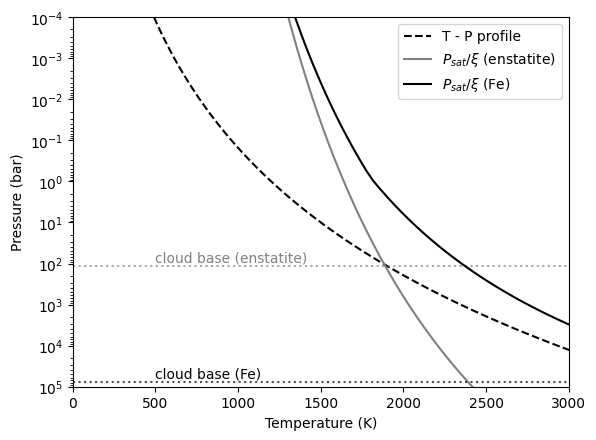

In [6]:
plt.plot(Tarr, Parr, color="black", ls="dashed", label="T - P profile")
plt.plot(Tarr,
         P_enstatite / MolMR_enstatite,
         label="$P_{sat}/\\xi$ (enstatite)",
         color="gray")
plt.axhline(Pbase_enstatite, color="gray", alpha=0.7, ls="dotted")
plt.text(500, Pbase_enstatite * 0.8, "cloud base (enstatite)", color="gray")

plt.plot(Tarr, P_fe_sol / MolMR_Fe, label="$P_{sat}/\\xi$ (Fe)", color="black")
plt.axhline(Pbase_Fe_sol, color="black", alpha=0.7, ls="dotted")
plt.text(500, Pbase_Fe_sol * 0.8, "cloud base (Fe)", color="black")

plt.yscale("log")
plt.ylim(1.e-4, 1.e5)
plt.xlim(0, 3000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.savefig("pbase.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("pbase.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute Mass Mixing Ratio (MMRs) of clouds. In this block, we first convert mol mixing ratio of condensates to MMR, then computes a cloud profile.

In [7]:
from exojax.atm.amclouds import mixing_ratio_cloud_profile
from exojax.spec.molinfo import molmass_isotope
from exojax.atm.mixratio import vmr2mmr
fsed = 3.
muc_enstatite = molmass_isotope("MgSiO3")
MMRbase_enstatite = vmr2mmr(MolMR_enstatite, muc_enstatite,mu)
MMRc_enstatite = mixing_ratio_cloud_profile(Parr, Pbase_enstatite, fsed, MMRbase_enstatite)

muc_Fe = molmass_isotope("Fe")
MMRbase_Fe = vmr2mmr(MolMR_Fe,muc_Fe,mu)
MMRc_Fe = mixing_ratio_cloud_profile(Parr, Pbase_Fe_sol, fsed, MMRbase_Fe)

['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 'C2H2', 'C2H6', 'PH3', 'COF2', 'SF6', 'H2S', 'HCOOH', 'HO2', 'O', 'ClONO2', 'NO+', 'HOBr', 'C2H4', 'CH3OH', 'CH3Br', 'CH3CN', 'CF4', 'C4H2', 'HC3N', 'H2', 'CS', 'SO3', 'C2N2', 'COCl2', 'SO', 'CH3F', 'GeH4', 'CS2', 'CH3I', 'NF3']
['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 'C2H2', 'C2H6', 'PH3', 'COF2', 'SF6', 'H2S', 'HCOOH', 'HO2', 'O', 'ClONO2', 'NO+', 'HOBr', 'C2H4', 'CH3OH', 'CH3Br', 'CH3CN', 'CF4', 'C4H2', 'HC3N', 'H2', 'CS', 'SO3', 'C2N2', 'COCl2', 'SO', 'CH3F', 'GeH4', 'CS2', 'CH3I', 'NF3']


/home/kawahara/exojax/src/exojax/spec/molinfo.py:64: UserWarning: db_HIT is set as True, but the molecular name 'MgSiO3' does not exist in the HITRAN database. So set db_HIT as False. For reference, all the available molecules in the HITRAN database are as follows:
  warnings.warn(warn_msg, UserWarning)
/home/kawahara/exojax/src/exojax/spec/molinfo.py:64: UserWarning: db_HIT is set as True, but the molecular name 'Fe' does not exist in the HITRAN database. So set db_HIT as False. For reference, all the available molecules in the HITRAN database are as follows:
  warnings.warn(warn_msg, UserWarning)


The followings are the base pressures for enstatite and Fe.

In [8]:
print(Pbase_enstatite, Pbase_Fe_sol)

114.975746 77426.445


Here is the MMR distribution.

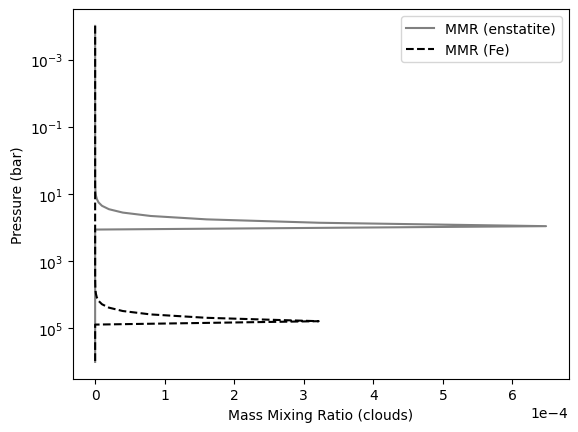

In [9]:
plt.figure()
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(MMRc_enstatite, Parr, color="gray", label="MMR (enstatite)")
plt.plot(MMRc_Fe, Parr, color="black", ls="dashed", label="MMR (Fe)")



plt.yscale("log")
#plt.ylim(1.e-7, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Mass Mixing Ratio (clouds)")
plt.ylabel("Pressure (bar)")
plt.savefig("mmrcloud.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("mmrcloud.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Computes dynamic viscosity in H2 atmosphere (cm/g/s)

In [10]:
from exojax.atm.viscosity import eta_Rosner, calc_vfactor

T = np.logspace(np.log10(1000), np.log10(2000))
vfactor, Tr = calc_vfactor("H2")
eta = eta_Rosner(T, vfactor)

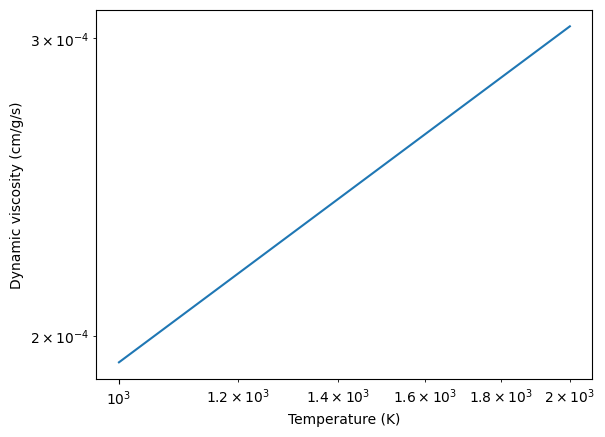

In [11]:
plt.plot(T, eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

The pressure scale height can be computed using atm.atmprof.Hatm.

In [12]:
from exojax.atm.atmprof import pressure_scale_height
T = 1000  #K
print("scale height=", pressure_scale_height(1.e5, T, mu), "cm")


scale height= 361498.2549385839 cm


We need the substance density of condensates. 

In [13]:
from exojax.atm.condensate import condensate_substance_density, name2formula

deltac_enstatite = condensate_substance_density[name2formula["enstatite"]]
deltac_Fe = condensate_substance_density["Fe"]


Let's compute the terminal velocity. 
We can compute the terminal velocity of cloud particle using atm.vterm.vf.
vmap is again applied to vf.

In [14]:
from exojax.atm.viscosity import calc_vfactor, eta_Rosner
from exojax.atm.vterm import terminal_velocity
from jax import vmap

vfactor, trange = calc_vfactor(atm="H2")
rarr = jnp.logspace(-6, -4, 2000)  #cm
drho = deltac_enstatite - rho
eta_fid = eta_Rosner(Tarr, vfactor)

g = 1.e5
vf_vmap = vmap(terminal_velocity, (None, None, 0, 0, 0))
vfs = vf_vmap(rarr, g, eta_fid, drho, rho)


Kzz/L will be used to calibrate $r_w$. following Ackerman and Marley 2001  

In [15]:
#sigmag:sigmag parameter (geometric standard deviation) in the lognormal distribution of condensate size, defined by (9) in AM01, must be sigmag > 1

Kzz = 1.e5  #cm2/s
sigmag = 2.0 # > 1
alphav = 1.3
L = pressure_scale_height(g, 1500, mu)


In [16]:
Kzz/L

0.18441767216274083

Text(0.5, 0, 'condensate size (cm)')

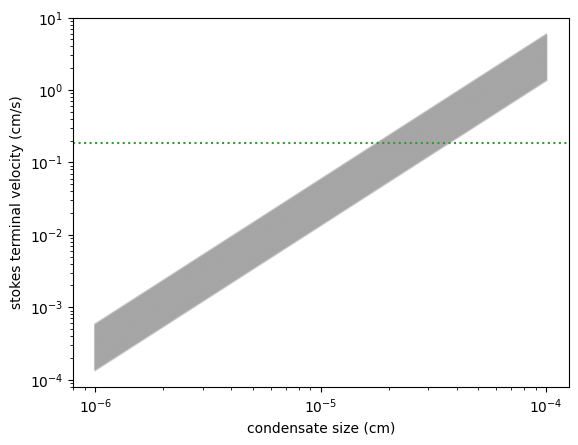

In [17]:
for i in range(0, len(Tarr)):
    plt.plot(rarr, vfs[i, :], alpha=0.2, color="gray")
plt.xscale("log")
plt.yscale("log")
plt.axhline(Kzz / L, label="Kzz/H", color="C2", ls="dotted")
plt.ylabel("stokes terminal velocity (cm/s)")
plt.xlabel("condensate size (cm)")

Find the intersection.

In [18]:
from exojax.atm.amclouds import find_rw

vfind_rw = vmap(find_rw, (None, 0, None), 0)
rw = vfind_rw(rarr, vfs, Kzz / L)


Then, $r_g$ can be computed from $r_w$ and other quantities.

In [19]:
from exojax.atm.amclouds import get_rg

rg = get_rg(rw, fsed, alphav, sigmag)


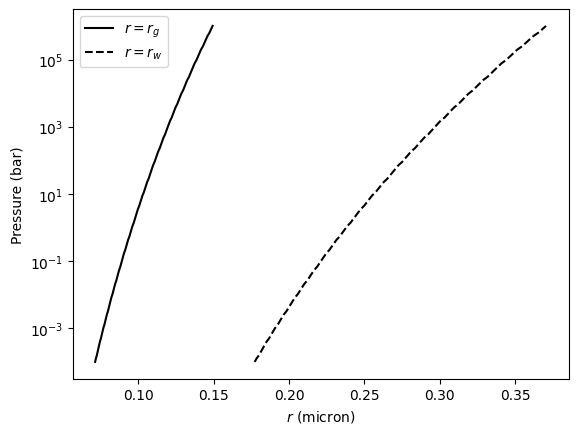

In [20]:
plt.plot(rg * 1.e4, Parr, label="$r=r_g$", color="black")
plt.plot(rw * 1.e4, Parr, ls="dashed", label="$r=r_w$", color="black")
#plt.ylim(1.e-7, 10000)
plt.xlabel("$r$ (micron)")
plt.ylabel("Pressure (bar)")
plt.yscale("log")
plt.savefig("rgrw.png")
plt.legend()

These processes can be reprodced using `AmpAmcloud`, which uses `PdbCloud` as one of the input arguments. Here, we show an example:

In [21]:
from exojax.atm.atmphys import AmpAmcloud
from exojax.spec.pardb import PdbCloud
pdb_enstatite = PdbCloud("MgSiO3")
pdb_Fe = PdbCloud("Fe")

amp = AmpAmcloud(pdb_enstatite,bkgatm="H2")
rg, MMRc = amp.calc_ammodel(Parr,Tarr,mu,MMRc_enstatite,gravity,fsed,sigmag,Kzz,MMRbase_enstatite,alphav=alphav)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/MgSiO3.refrind
Miegrid file does not exist at  .database/particulates/virga/miegrid_lognorm_MgSiO3.mg.npz
Generate miegrid file using pdb.generate_miegrid if you use Mie scattering
.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/Fe.refrind
Miegrid file does not exist at  .database/particulates/virga/miegrid_lognorm_Fe.mg.npz
Generate miegrid file using pdb.generate_miegrid if you use Mie scattering


We found here the particle size is basically sub-micron.  
Here, we try to use the geometric cross section instead though this is sometimes wrong, depending on the wavelength. 

In [22]:
from exojax.spec.layeropacity import layer_optical_depth_cloudgeo

dtau_enstatite = layer_optical_depth_cloudgeo(Parr, deltac_enstatite, MMRc_enstatite, rg, sigmag, g)
dtau_Fe = layer_optical_depth_cloudgeo(Parr, deltac_Fe, MMRc_Fe, rg, sigmag, g)


/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


The Mie scattering can be computed using `OpaMie`.

In [23]:
from exojax.utils.grids import wavenumber_grid
from exojax.spec.unitconvert import wav2nu

N = 1000
wavelength_start = 5000.0 #AA
wavelength_end = 15000.0 #AA


margin = 10  # cm-1
nus_start = wav2nu(wavelength_end, unit="AA") - margin
nus_end = wav2nu(wavelength_start, unit="AA") + margin
nugrid, wav, res = wavenumber_grid(nus_start, nus_end, N, xsmode="lpf", unit="cm-1")



from exojax.spec.opacont import OpaMie
opa_enstatite = OpaMie(pdb_enstatite, nugrid)
opa_Fe = OpaMie(pdb_Fe, nugrid)

rg=1.e-4 #0.1um
#beta0, betasct, g = opa.mieparams_vector(rg,sigmag) # if you've already generated miegrid 
beta0, betasct, g = opa_enstatite.mieparams_vector_direct_from_pymiescatt(rg,sigmag) # uses direct computation of Mie params using PyMieScatt
beta0_Fe, betasct_Fe, g_Fe = opa_Fe.mieparams_vector_direct_from_pymiescatt(rg,sigmag) # uses direct computation of Mie params using PyMieScatt


from exojax.spec.layeropacity import layer_optical_depth_clouds_lognormal

dtau_enstatite_mie = layer_optical_depth_clouds_lognormal(
    dParr, beta0, deltac_enstatite, MMRc_enstatite, rg, sigmag, gravity
)
dtau_Fe_mie = layer_optical_depth_clouds_lognormal(
    dParr, beta0_Fe, deltac_Fe, MMRc_Fe, rg, sigmag, gravity
)



/home/kawahara/exojax/src/exojax/utils/grids.py:142: UserWarning: Resolution may be too small. R=907.6757560767178
  warnings.warn('Resolution may be too small. R=' + str(resolution),


xsmode =  lpf
xsmode assumes ESLOG in wavenumber space: mode=lpf
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order


100%|██████████| 63/63 [00:20<00:00,  3.09it/s]


The difference of the geometric approximation and Mie scattering is a bit.

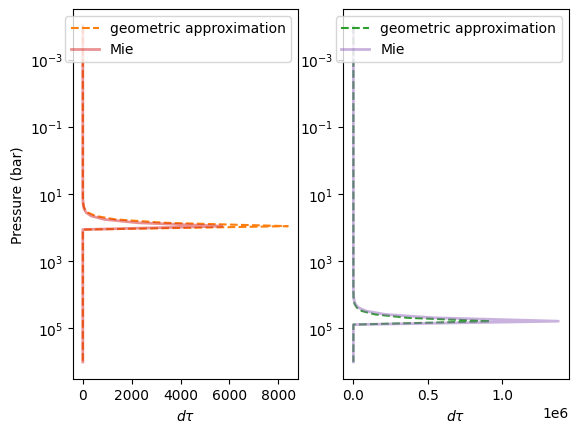

In [24]:
fig = plt.figure()
ax=fig.add_subplot(121)
plt.plot(dtau_enstatite, Parr, color="C1", ls="dashed", label="geometric approximation")
plt.plot(np.median(dtau_enstatite_mie,axis=1), Parr, color="C3", label="Mie",alpha=0.5,lw=2)
plt.legend()
plt.yscale("log")
plt.xlabel("$d\\tau$")
plt.ylabel("Pressure (bar)")
#plt.xscale("log")
plt.gca().invert_yaxis()

ax=fig.add_subplot(122)
plt.plot(dtau_Fe, Parr, color="C2", ls="dashed", label="geometric approximation")
plt.plot(np.median(dtau_Fe_mie,axis=1), Parr, color="C4",alpha=0.5, label="Mie",lw=2)

plt.legend()
plt.yscale("log")
plt.xlabel("$d\\tau$")
#plt.xscale("log")
plt.gca().invert_yaxis()
plt.show()

Let's compare with CIA

In [25]:
#CIA

from exojax.spec import contdb
cdbH2H2 = contdb.CdbCIA('.database/H2-H2_2011.cia', nugrid)

H2-H2


In [26]:
from exojax.spec.layeropacity import layer_optical_depth_CIA
from exojax.atm.mixratio import mmr2vmr

mmrH2 = 0.74
molmassH2 = molmass_isotope("H2")
vmrH2 = mmr2vmr(mmrH2, mu, molmassH2)
dtaucH2H2 = layer_optical_depth_CIA(
    nugrid,
    Tarr,
    Parr,
    dParr,
    vmrH2,
    vmrH2,
    mu,
    gravity,
    cdbH2H2.nucia,
    cdbH2H2.tcia,
    cdbH2H2.logac,
)

In [27]:
dtau = dtaucH2H2 + dtau_enstatite_mie+ dtau_Fe_mie


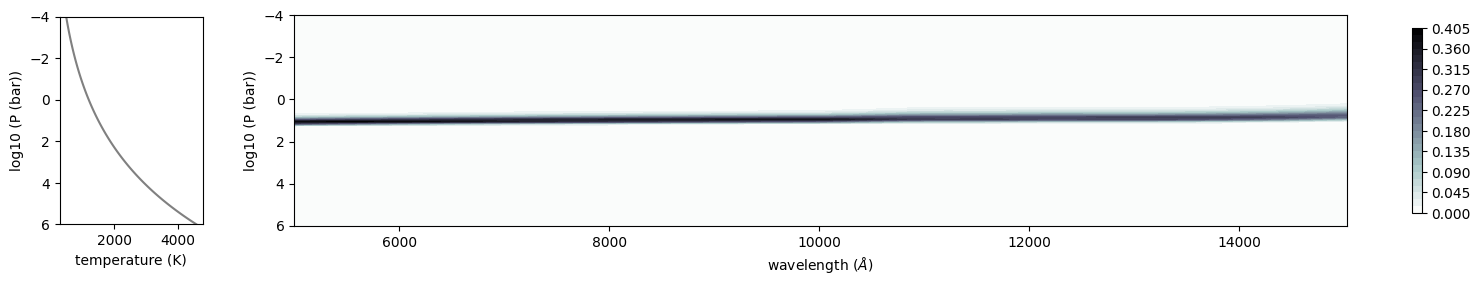

In [28]:
from exojax.plot.atmplot import plotcf

plotcf(nugrid, dtau, Tarr, Parr, dParr, unit="AA")
plt.show()

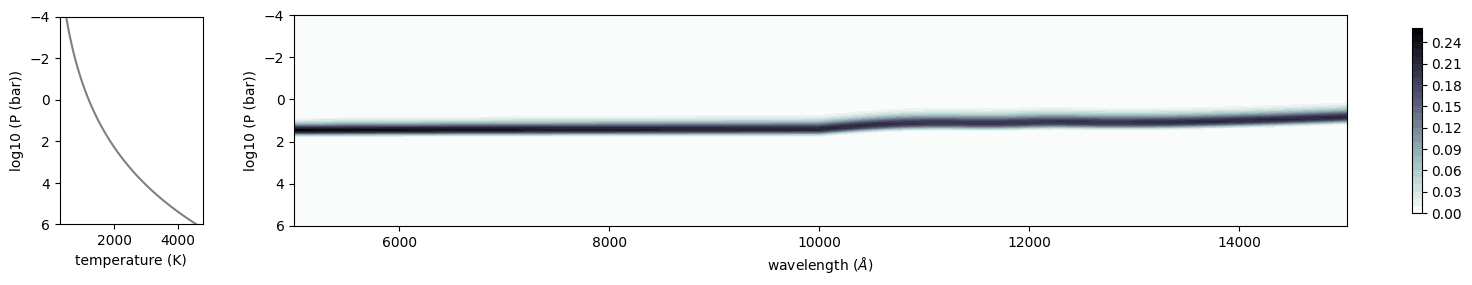

In [29]:
from exojax.plot.atmplot import plotcf

plotcf(nugrid, dtaucH2H2, Tarr, Parr, dParr, unit="AA")
plt.show()

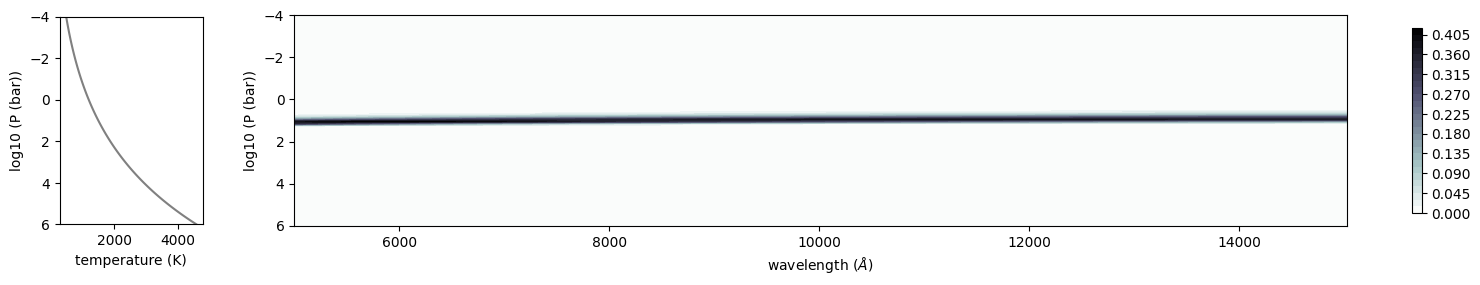

In [30]:
from exojax.plot.atmplot import plotcf

plotcf(nugrid,
       dtau_enstatite_mie,
       Tarr,
       Parr,
       dParr,
       unit="AA")
plt.show()

In [32]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun_emis_pureabs_fbased2st as rtrun
#from exojax.spec.rtransfer import rtrun_emis_pureabs_ibased as rtrun
sourcef = planck.piBarr(Tarr, nugrid)
F0 = rtrun(dtau, sourcef)
F0CIA = rtrun(dtaucH2H2, sourcef)
F0cl = rtrun(dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2), sourcef)


In this case, the effect of clouds and CIA are comparable with each other

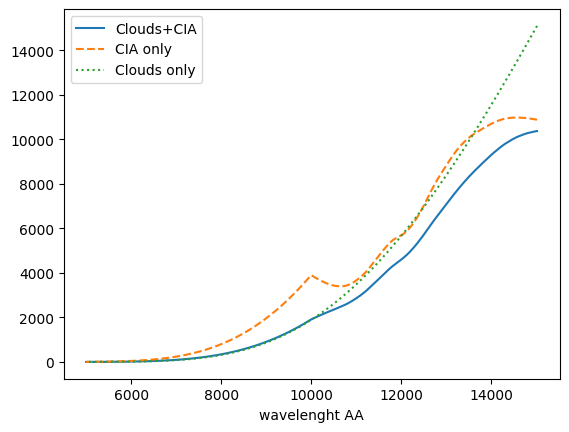

In [33]:
plt.plot(wav, F0, label="Clouds+CIA")
plt.plot(wav, F0CIA, label="CIA only", ls="dashed")
plt.plot(wav, F0cl, label="Clouds only", ls="dotted")
plt.xlabel("wavelenght AA")
plt.legend()
plt.show()